In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.1.0+cu118


In [2]:
batch_size=256
learning_rate=0.0002
num_epoch=10


In [3]:
mnist_train=dset.MNIST(root="../",train=True, transform=transforms.ToTensor(),target_transform=None,download=True)
mnist_test=dset.MNIST(root="../",train=False, transform=transforms.ToTensor(),target_transform=None,download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 124805511.59it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31562192.24it/s]


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35392420.89it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14941591.19it/s]


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [4]:
print(mnist_train.__getitem__(0)[0].size(),mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(),mnist_test.__len__())

print(len(mnist_train),len(mnist_test))


torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


In [5]:
train_loader=DataLoader(mnist_train,batch_size=batch_size,shuffle=True, num_workers=2, drop_last=True)
test_loader=DataLoader(mnist_test,batch_size=batch_size,shuffle=False, num_workers=2, drop_last=True)

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.fc_layer = nn.Sequential(
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, 10)
        )

  def forward(self,x):
    out=self.layer(x)
    out = out.view(out.size(0), -1)

    out=self.fc_layer(out)
    return out

In [7]:
device=torch.device("cuda:0 "if torch.cuda.is_available() else"cpu")

print(device)

model=CNN().to(device)

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


cpu


In [8]:
loss_arr=[]
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)
    y_=label.to(device)

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j % 1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())


tensor(2.3108, grad_fn=<NllLossBackward0>)
tensor(0.9687, grad_fn=<NllLossBackward0>)
tensor(0.6490, grad_fn=<NllLossBackward0>)
tensor(0.4184, grad_fn=<NllLossBackward0>)
tensor(0.3262, grad_fn=<NllLossBackward0>)
tensor(0.3060, grad_fn=<NllLossBackward0>)
tensor(0.2713, grad_fn=<NllLossBackward0>)
tensor(0.2192, grad_fn=<NllLossBackward0>)
tensor(0.2246, grad_fn=<NllLossBackward0>)
tensor(0.2415, grad_fn=<NllLossBackward0>)


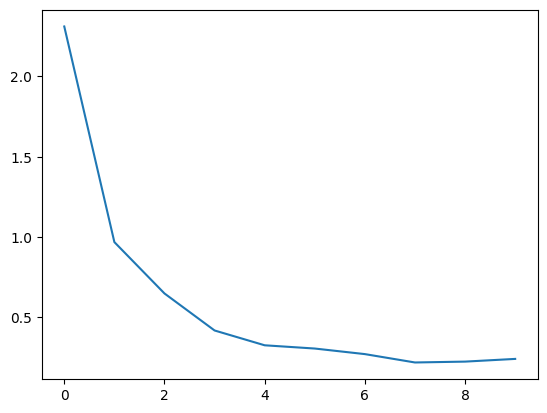

In [9]:
plt.plot(loss_arr)
plt.show()

In [10]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)

    output=model.forward(x)

    _,output_index=torch.max(output,1)

    total+=label.size(0)
    correct+=(output_index==y_).sum().float()

  print("Accuracy of Test Data:{}%".format(100*correct/total))

Accuracy of Test Data:94.46113586425781%
